# 🧠 Clustering & DBSCAN – A Learning Journey  

This notebook is part of my open learning series on **clustering algorithms** — a space where I document what I learn, test ideas, and share the intuition behind them.  

My goal isn’t just to show results, but to **teach through exploration**:  
each section represents a real milestone in understanding how clustering works — from the classic **K-Means** method to the more flexible **DBSCAN** approach that handles density and noise.  

You’ll find:
- Clear explanations and step-by-step code  
- Visualizations to make every concept intuitive  
- Modular sections that mirror short LinkedIn posts  

By the end, I hope this serves as both a **reference and a teaching resource** for anyone learning clustering.


## 🗺️ Project Roadmap  

This notebook grows as I continue my learning.  
Each section below corresponds to a LinkedIn post where I explain the key idea, code, and visuals in a simple way.

| # | Section | Status | Focus |
|---|----------|--------|--------|
| 1 | Why Clustering? | ✅ | What clustering means and why we use it |
| 2 | K-Means Basics | ✅ | How K-Means forms clusters through iteration |
| 3 | K-Means Failures | ⬜ | Why K-Means struggles on complex or uneven data |
| 4 | DBSCAN Intuition | ⬜ | Core, border, and noise points explained visually |
| 5 | Cluster Expansion | ⬜ | How DBSCAN grows clusters from core points |
| 6 | Tuning ε & minPts | ⬜ | Finding the right parameters and understanding their effects |
| 7 | DBSCAN vs K-Means | ⬜ | Comparing both approaches and summarizing insights |


In [1]:
# ============================================================
# 📦 Setup
# ============================================================

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Aesthetic settings
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.titlesize"] = 13

# Directory for saving plots
import os
IMGS_DIR = "imgs"
os.makedirs(IMGS_DIR, exist_ok=True)

def savefig(name, dpi=200):
    """Helper to save figures neatly inside the imgs folder."""
    path = os.path.join(IMGS_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    print(f"✅ Figure saved to {path}")


## 1️⃣ Why Clustering?  

Before we even train models or make predictions, we often face a simple question:  
**“What patterns exist in my data?”**  

That’s where *clustering* comes in. It’s a form of **unsupervised learning** —  
where we don’t have labels, but we want to discover structure.  

The goal of clustering is to **group similar data points together** so that  
objects in the same cluster are more alike than those in different clusters.  

You’ll find clustering everywhere:  
- 🧬 grouping genes with similar expression patterns  
- 🛍️ segmenting customers by behavior  
- 📷 organizing image datasets by visual similarity  
- 🩺 identifying patient subtypes in medical data  

To visualize this, let’s start with a simple example:  
how a random set of points can reveal hidden patterns once we apply *any* clustering algorithm.  
Here, we’ll use one of the simplest methods — **K-Means** — just to see how clustering organizes unlabeled data.  
We’ll dive deeper into how K-Means actually works in the *next section*.


✅ Figure saved to imgs\why_clustering.png


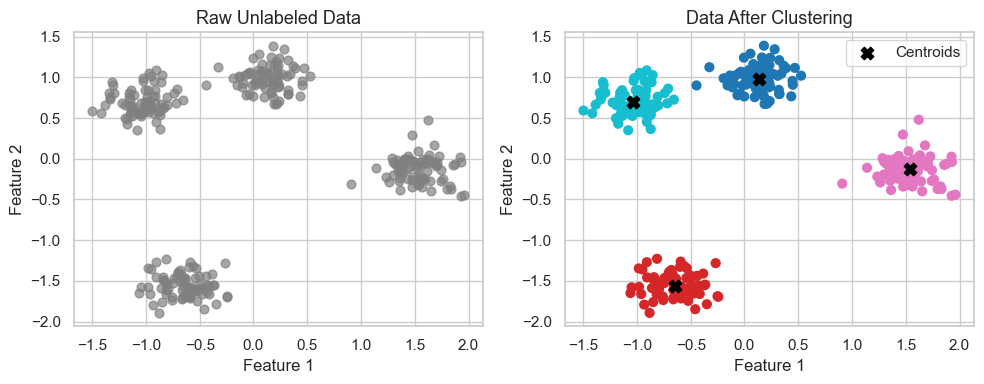

In [2]:
# ============================================================
# 🎨 Visualization: Why Clustering?
# ============================================================

# Create a synthetic dataset (unlabeled data)
X, _ = make_blobs(
    n_samples=300, centers=4, cluster_std=1.0, random_state=42
)

# Standardize features for better scaling
X_scaled = StandardScaler().fit_transform(X)

# Apply K-Means just to show what clustering *does*
kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# ---- Plot ----
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left: Unlabeled raw data
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c="gray", alpha=0.7, s=40)
axes[0].set_title("Raw Unlabeled Data")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

# Right: After clustering
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap="tab10", s=40)
axes[1].scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    c="black",
    s=80,
    marker="X",
    label="Centroids",
)
axes[1].set_title("Data After Clustering")
axes[1].legend(loc="upper right", frameon=True)
axes[1].set_xlabel("Feature 1")
axes[1].set_ylabel("Feature 2")

plt.tight_layout()
savefig("why_clustering.png")
plt.show()


### 💭 Reflection  

Clustering is one of those concepts that looks simple — until you realize how powerful it actually is.  
From an unlabeled cloud of points, the algorithm can uncover structure, relationships, and meaning.  

In the example above, we didn’t tell the model what to look for.  
It *discovered* the groups based purely on distance and similarity.  

That’s the beauty of unsupervised learning:  
it helps us **see order in chaos** — a first step before any advanced modeling.  

In the next part, we’ll take a closer look at the algorithm we just used — **K-Means** —  
to understand how it identifies those clusters step by step.



### 2️⃣ K-Means Basics — From Random Centroids to Convergence

K-Means alternates two simple steps until assignments stop changing:

1) **Assign** each point to its nearest centroid  
2) **Update** each centroid to the mean of its assigned points  

The **“K”** in K-Means simply represents the **number of clusters** (and centroids) we want to form.  
Each centroid represents the “center” of one cluster, and through iteration, these centers gradually move until the configuration stabilizes.

Below, we’ll animate this process — random initialization → first assignments → centroid moves → repeat → convergence.  
This makes the intuition clear: centroids migrate toward the “center of mass” of their assigned points.  
(Next post: where these assumptions break down.)


✅ GIF saved to imgs\kmeans_process.gif


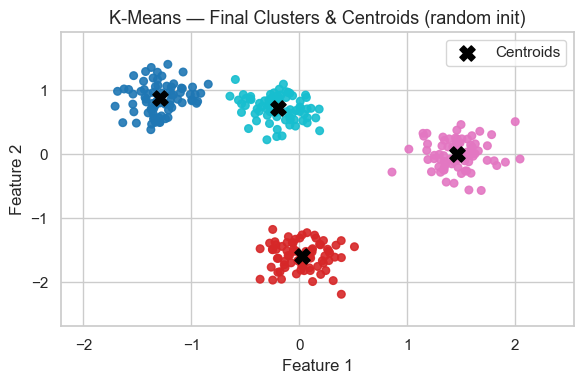

✅ PNG saved to imgs\kmeans_final.png


In [12]:
# ============================================================
# 🎞️ Pedagogical K-Means GIF: init → assign → move (random init)
# Shows phases clearly with tweened centroid motion
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import os

# imageio for GIF
try:
    import imageio.v2 as imageio
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imageio"])
    import imageio.v2 as imageio

# ---------- Data ----------
X, _ = make_blobs(n_samples=300, centers=4, cluster_std=1.3, random_state=7)
X = StandardScaler().fit_transform(X)

k = 4
rng = np.random.default_rng()   # no seed -> fresh randomness each run
IMGS_DIR = "imgs"; os.makedirs(IMGS_DIR, exist_ok=True)

def assign_labels(X, C):
    d2 = ((X[:, None, :] - C[None, :, :])**2).sum(axis=2)
    return d2.argmin(axis=1)

def update_centroids(X, y, k, rng):
    C_new = np.zeros((k, X.shape[1]))
    for j in range(k):
        m = (y == j)
        if m.any():
            C_new[j] = X[m].mean(axis=0)
        else:  # handle empty cluster
            C_new[j] = X[rng.integers(0, len(X))]
    return C_new

def add_frame(ax, X, y_colors=None, C=None, title=""):
    if y_colors is None:
        ax.scatter(X[:,0], X[:,1], c="lightgray", s=30, alpha=0.9)
    else:
        ax.scatter(X[:,0], X[:,1], c=y_colors, s=30, alpha=0.9, cmap="tab10")
    if C is not None:
        ax.scatter(C[:,0], C[:,1], c="black", s=120, marker="X", label="Centroids")
        ax.legend(loc="upper right", frameon=True)
    ax.set_title(title)
    ax.set_xlabel("Feature 1"); ax.set_ylabel("Feature 2")
    ax.set_xlim(X[:,0].min()-0.5, X[:,0].max()+0.5)
    ax.set_ylim(X[:,1].min()-0.5, X[:,1].max()+0.5)
    plt.tight_layout()

def capture(fig):
    fig.canvas.draw()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    h, w = fig.canvas.get_width_height()[1], fig.canvas.get_width_height()[0]
    return buf.reshape(h, w, 4)[..., :3]  # drop alpha

# ----- Random init (plain K-Means) -----
init_idx = rng.choice(len(X), size=k, replace=False)
C = X[init_idx].copy()

frames = []

# Frame 0: Initialization (no colors)
fig, ax = plt.subplots(figsize=(6,4))
add_frame(ax, X, y_colors=None, C=C, title="Initialization: random centroids")
frames.append(capture(fig)); plt.close(fig)

max_iter = 15
for it in range(1, max_iter+1):
    # Phase 1: Assign (color points; centroids fixed)
    y = assign_labels(X, C)
    fig, ax = plt.subplots(figsize=(6,4))
    add_frame(ax, X, y_colors=y, C=C, title=f"Iteration {it}: Assign to nearest centroid")
    frames.append(capture(fig)); plt.close(fig)

    # Phase 2: Update (animate centroid movement)
    C_new = update_centroids(X, y, k, rng)

    # tween centroids along straight lines for visibility
    steps = 6  # more steps = smoother motion
    for s in range(1, steps+1):
        t = s/steps
        Ct = (1-t)*C + t*C_new
        fig, ax = plt.subplots(figsize=(6,4))
        # keep points colored by current assignment during movement
        add_frame(ax, X, y_colors=y, C=Ct, title=f"Iteration {it}: Update centroids (moving)")
        # draw path lines from old to new (light gray)
        for j in range(k):
            ax.plot([C[j,0], C_new[j,0]], [C[j,1], C_new[j,1]], linestyle="--", alpha=0.5, color="gray")
        frames.append(capture(fig)); plt.close(fig)

    # check convergence
    if np.allclose(C, C_new, atol=1e-6):
        C = C_new
        # Final frame: converged
        y = assign_labels(X, C)
        fig, ax = plt.subplots(figsize=(6,4))
        add_frame(ax, X, y_colors=y, C=C, title=f"Converged after {it} iteration(s)")
        frames.append(capture(fig)); plt.close(fig)
        break

    C = C_new

# Save GIF
gif_path = os.path.join(IMGS_DIR, "kmeans_process.gif")
imageio.mimsave(gif_path, frames, duration=0.45)  # adjust speed if needed
print(f"✅ GIF saved to {gif_path}")

# Save final PNG
y = assign_labels(X, C)
fig, ax = plt.subplots(figsize=(6,4))
add_frame(ax, X, y_colors=y, C=C, title="K-Means — Final Clusters & Centroids (random init)")
png_path = os.path.join(IMGS_DIR, "kmeans_final.png")
plt.savefig(png_path, dpi=200, bbox_inches="tight"); plt.show()
print(f"✅ PNG saved to {png_path}")


### 🧩 Reflection — K-Means Behavior  

In this example, we implemented the K-Means algorithm **from scratch** using random initialization.  
The animation clearly shows how centroids move after each iteration until convergence.  

✅ Key takeaways:  
- K-Means assigns each point to its nearest centroid and recomputes centroids iteratively.  
- The final clusters are compact and well-separated.  
- Random initialization affects results — rerunning may lead to different final clusters.  

📘 **P.S.**  
In the previous section, we used scikit-learn’s built-in `KMeans` function to quickly demonstrate clustering.  
Here, we reimplemented it manually to visualize its inner workings — initialization, assignment, and centroid updates —  
which aren’t visible when using the library version.  
This helps build a deeper understanding of how K-Means actually converges.
